<a href="https://colab.research.google.com/github/farkhanAdhitama/asphalt-road-damage-detection-using-you-only-look-once-YOLOv9-algorithm/blob/main/asphalt-road-damage-detection-YOLOv9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skripsi : Deteksi Kerusakan Jalan Aspal Menggunakan Algoritma YOLOv9

**Keterangan :** \
image size : 640x640 fit in \
lr 0.001\
epoch : 150 \
batch : 16 \
hyp : default \
Data : 80:10:10

# GPU Check

In [ ]:
!nvidia-smi

Thu Nov 28 10:21:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Install YOLOv9

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!git clone https://github.com/WongKinYiu/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 781, done.
remote: Total 781 (delta 0), reused 0 (delta 0), pack-reused 781 (from 1)
Receiving objects: 100% (781/781), 3.27 MiB | 6.53 MiB/s, done.
Resolving deltas: 100% (331/331), done.
/content/yolov9
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.0 MB/s eta 0:00:00


# Download Model Weights

In [ ]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [ ]:
!ls -la {HOME}/weights

total 402452
drwxr-xr-x 2 root root      4096 Nov 28 10:21 .
drwxr-xr-x 1 root root      4096 Nov 28 10:21 ..
-rw-r--r-- 1 root root  51508261 Feb 18  2024 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18  2024 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18  2024 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18  2024 yolov9-e.pt


# Install Roboflow

In [ ]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.7 MB/s eta 0:00:00


# Download Data

Dataset disimpan dalam folder {HOME}/yolov9 agar bisa dilakukan proses pelatihan

In [ ]:
%cd {HOME}/yolov9

/content/yolov9


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="mKfBaoS5ZsLfPjDXBp1i")
project = rf.workspace("muhammadfarkhan").project("deteksi-kerusakan-jalan-qndim")
version = project.version(26)
dataset = version.download("yolov9")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Deteksi-Kerusakan-Jalan-26 in yolov9:: 100%|██████████| 6654/6654 [00:01<00:00, 4439.17it/s]


# Distribusi Dataset
Dataset dibagi menjadi 80% data training, 10% data validation, dan 10% data testing. Total 3321 dataset gambar.

In [ ]:
import os
from collections import Counter
import matplotlib.pyplot as plt
from collections import Counter

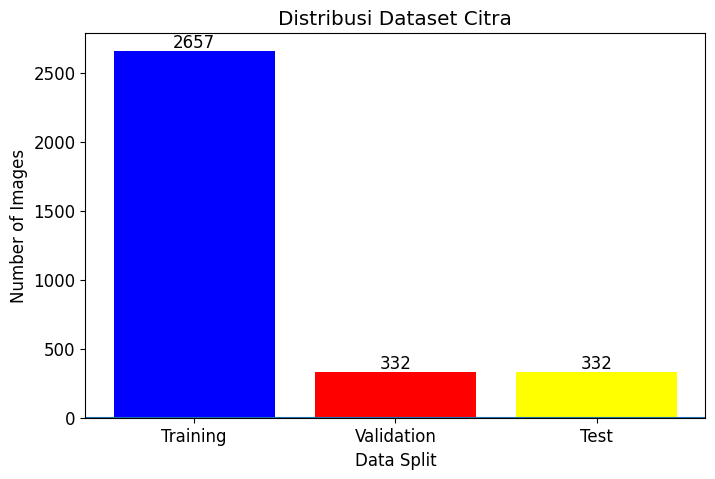

In [ ]:
train_dir = os.path.join(dataset.location, 'train/labels')
val_dir = os.path.join(dataset.location, 'valid/labels')
test_dir = os.path.join(dataset.location, 'test/labels')
train_count = len(os.listdir(train_dir))
val_count = len(os.listdir(val_dir))
test_count = len(os.listdir(test_dir))

labels = ['Training', 'Validation', 'Test']
counts = [train_count, val_count, test_count]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts, color=['blue', 'red', 'yellow'])
plt.xlabel('Data Split')
plt.ylabel('Number of Images')
plt.title('Distribusi Dataset Citra')
plt.axhline()
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')
plt.show()

In [ ]:
def plot_class_distribution(annotations_path, class_names, title="Distribusi Kelas Data"):
    # Hitung jumlah setiap kelas
    class_counter = Counter()
    for filename in os.listdir(annotations_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(annotations_path, filename)
            with open(file_path, 'r') as file:
                for line in file:
                    class_id = int(line.split()[0])
                    class_counter[class_id] += 1
    sorted_class_counts = {class_names[k]: class_counter[k] for k in sorted(class_names)}
    labels = list(sorted_class_counts.keys())
    counts = list(sorted_class_counts.values())
    plt.figure(figsize=(10, 5))
    bars = plt.bar(labels, counts, color=['blue', 'green', 'red', 'purple'])
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom')
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title(title)
    plt.show()

**Distribusi Data Training**

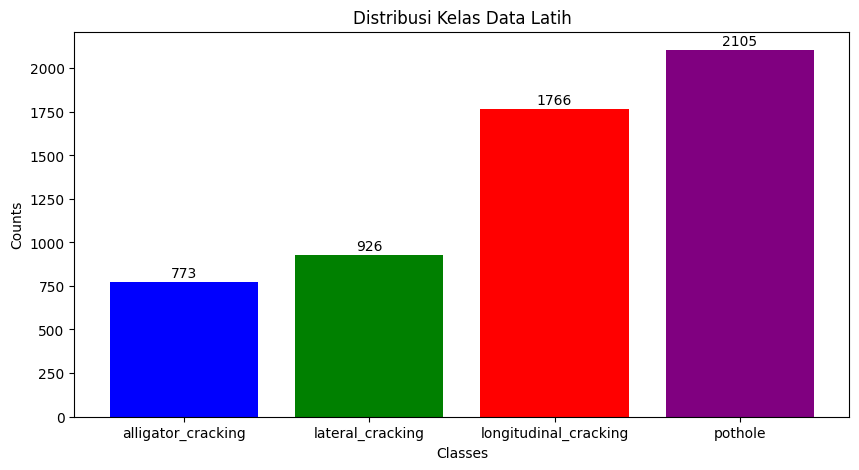

In [ ]:
annotations_path = os.path.join(dataset.location, 'train/labels')
class_names = {
    0: "alligator_cracking",
    1: "lateral_cracking",
    2: "longitudinal_cracking",
    3: "pothole"
}
plot_class_distribution(annotations_path, class_names, title="Distribusi Kelas Data Latih")

**Distribusi Data Validasi**

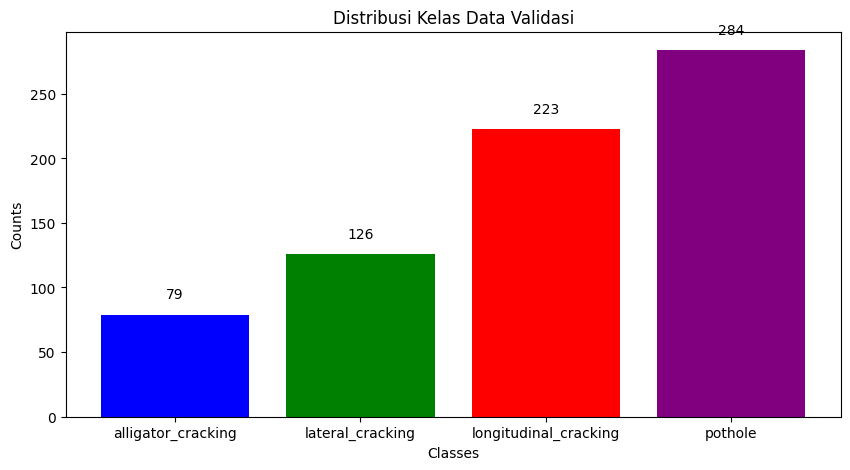

In [ ]:
annotations_path = os.path.join(dataset.location, 'valid/labels')
class_names = {
    0: "alligator_cracking",
    1: "lateral_cracking",
    2: "longitudinal_cracking",
    3: "pothole"
}
plot_class_distribution(annotations_path, class_names, title="Distribusi Kelas Data Validasi")

**Distribusi** Data Testing

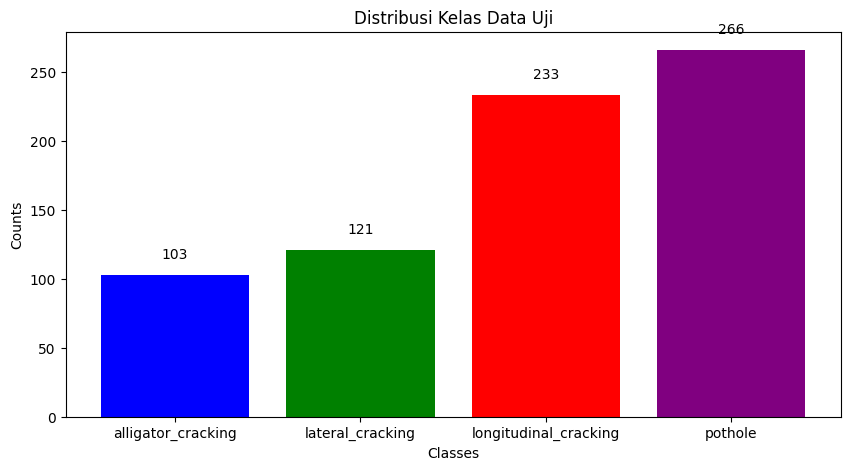

In [ ]:
annotations_path = os.path.join(dataset.location, 'test/labels')
class_names = {
    0: "alligator_cracking",
    1: "lateral_cracking",
    2: "longitudinal_cracking",
    3: "pothole"
}
plot_class_distribution(annotations_path, class_names, title="Distribusi Kelas Data Uji")

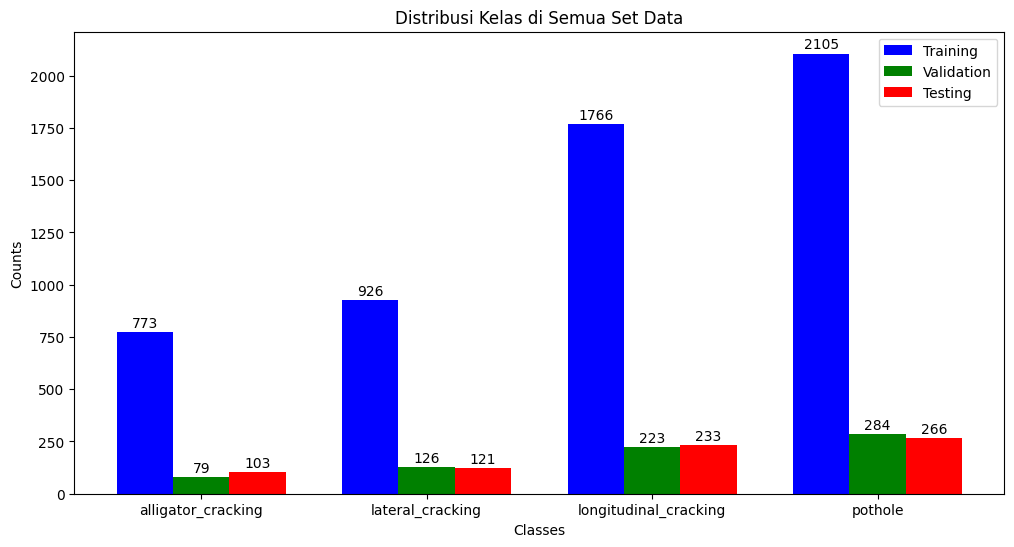

In [ ]:
import os
from collections import Counter
import matplotlib.pyplot as plt

train_annotations_path = os.path.join(dataset.location, 'train/labels')
valid_annotations_path = os.path.join(dataset.location, 'valid/labels')
test_annotations_path = os.path.join(dataset.location, 'test/labels')
class_names = {
    0: "alligator_cracking",
    1: "lateral_cracking",
    2: "longitudinal_cracking",
    3: "pothole"
}

# Menghitung jumlah setiap kelas di setiap set data
train_class_counter = Counter()
for filename in os.listdir(train_annotations_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(train_annotations_path, filename)
        with open(file_path, 'r') as file:
            for line in file:
                class_id = int(line.split()[0])
                train_class_counter[class_id] += 1

valid_class_counter = Counter()
for filename in os.listdir(valid_annotations_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(valid_annotations_path, filename)
        with open(file_path, 'r') as file:
            for line in file:
                class_id = int(line.split()[0])
                valid_class_counter[class_id] += 1

test_class_counter = Counter()
for filename in os.listdir(test_annotations_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(test_annotations_path, filename)
        with open(file_path, 'r') as file:
            for line in file:
                class_id = int(line.split()[0])
                test_class_counter[class_id] += 1

# Mengurutkan hasil berdasarkan nama kelas
sorted_train_class_counts = {class_names[k]: train_class_counter[k] for k in sorted(class_names)}
sorted_valid_class_counts = {class_names[k]: valid_class_counter[k] for k in sorted(class_names)}
sorted_test_class_counts = {class_names[k]: test_class_counter[k] for k in sorted(class_names)}

# Membuat grafik gabungan
labels = list(sorted_train_class_counts.keys())
train_counts = list(sorted_train_class_counts.values())
valid_counts = list(sorted_valid_class_counts.values())
test_counts = list(sorted_test_class_counts.values())

x = range(len(labels))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x, train_counts, width=width, label='Training', color='blue')
plt.bar([i + width for i in x], valid_counts, width=width, label='Validation', color='green')
plt.bar([i + 2 * width for i in x], test_counts, width=width, label='Testing', color='red')

for i, (train_count, valid_count, test_count) in enumerate(zip(train_counts, valid_counts, test_counts)):
    plt.text(i, train_count + 10, int(train_count), ha='center', va='bottom')
    plt.text(i + width, valid_count + 10, int(valid_count), ha='center', va='bottom')
    plt.text(i + 2 * width, test_count + 10, int(test_count), ha='center', va='bottom')

plt.xticks([i + width for i in x], labels)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Distribusi Kelas di Semua Set Data')
plt.legend()
plt.show()


# Data Training and Validation

In [ ]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 150 --img 640 --min-items 0 --close-mosaic 15\
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/content/yolov9
2024-08-09 23:55:40.789034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 23:55:41.042793: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 23:55:41.114913: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 23:55:41.533134: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-09 23:55:43.305244: W

# Training and Validation Result

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/results_yolov9/fix_skripsi_yolov9-c_640_lr0_001_150.zip -d /content/yolov9

Archive:  /content/drive/MyDrive/results_yolov9/fix_skripsi_yolov9-c_640_lr0_001_150.zip
   creating: /content/yolov9/train/
   creating: /content/yolov9/train/exp/
  inflating: /content/yolov9/train/exp/hyp.yaml  
  inflating: /content/yolov9/train/exp/opt.yaml  
  inflating: /content/yolov9/train/exp/val_batch1_labels.jpg  
   creating: /content/yolov9/train/exp/weights/
  inflating: /content/yolov9/train/exp/weights/best.pt  
  inflating: /content/yolov9/train/exp/weights/best_striped.pt  
  inflating: /content/yolov9/train/exp/weights/last_striped.pt  
  inflating: /content/yolov9/train/exp/weights/last.pt  
  inflating: /content/yolov9/train/exp/val_batch2_labels.jpg  
  inflating: /content/yolov9/train/exp/results.png  
  inflating: /content/yolov9/train/exp/train_batch0.jpg  
  inflating: /content/yolov9/train/exp/F1_curve.png  
  inflating: /content/yolov9/train/exp/val_batch2_pred.jpg  
  inflating: /content/yolov9/train/exp/R_curve.png  
  inflating: /content/yolov9/train/exp

In [ ]:
!ls {HOME}/yolov9/runs/train/exp/

confusion_matrix.png				    PR_curve.png	   val_batch0_pred.jpg
events.out.tfevents.1723116043.6d344e899063.1036.0  R_curve.png		   val_batch1_labels.jpg
F1_curve.png					    results.csv		   val_batch1_pred.jpg
hyp.yaml					    results.png		   val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg	   val_batch2_pred.jpg
labels.jpg					    train_batch1.jpg	   weights
opt.yaml					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


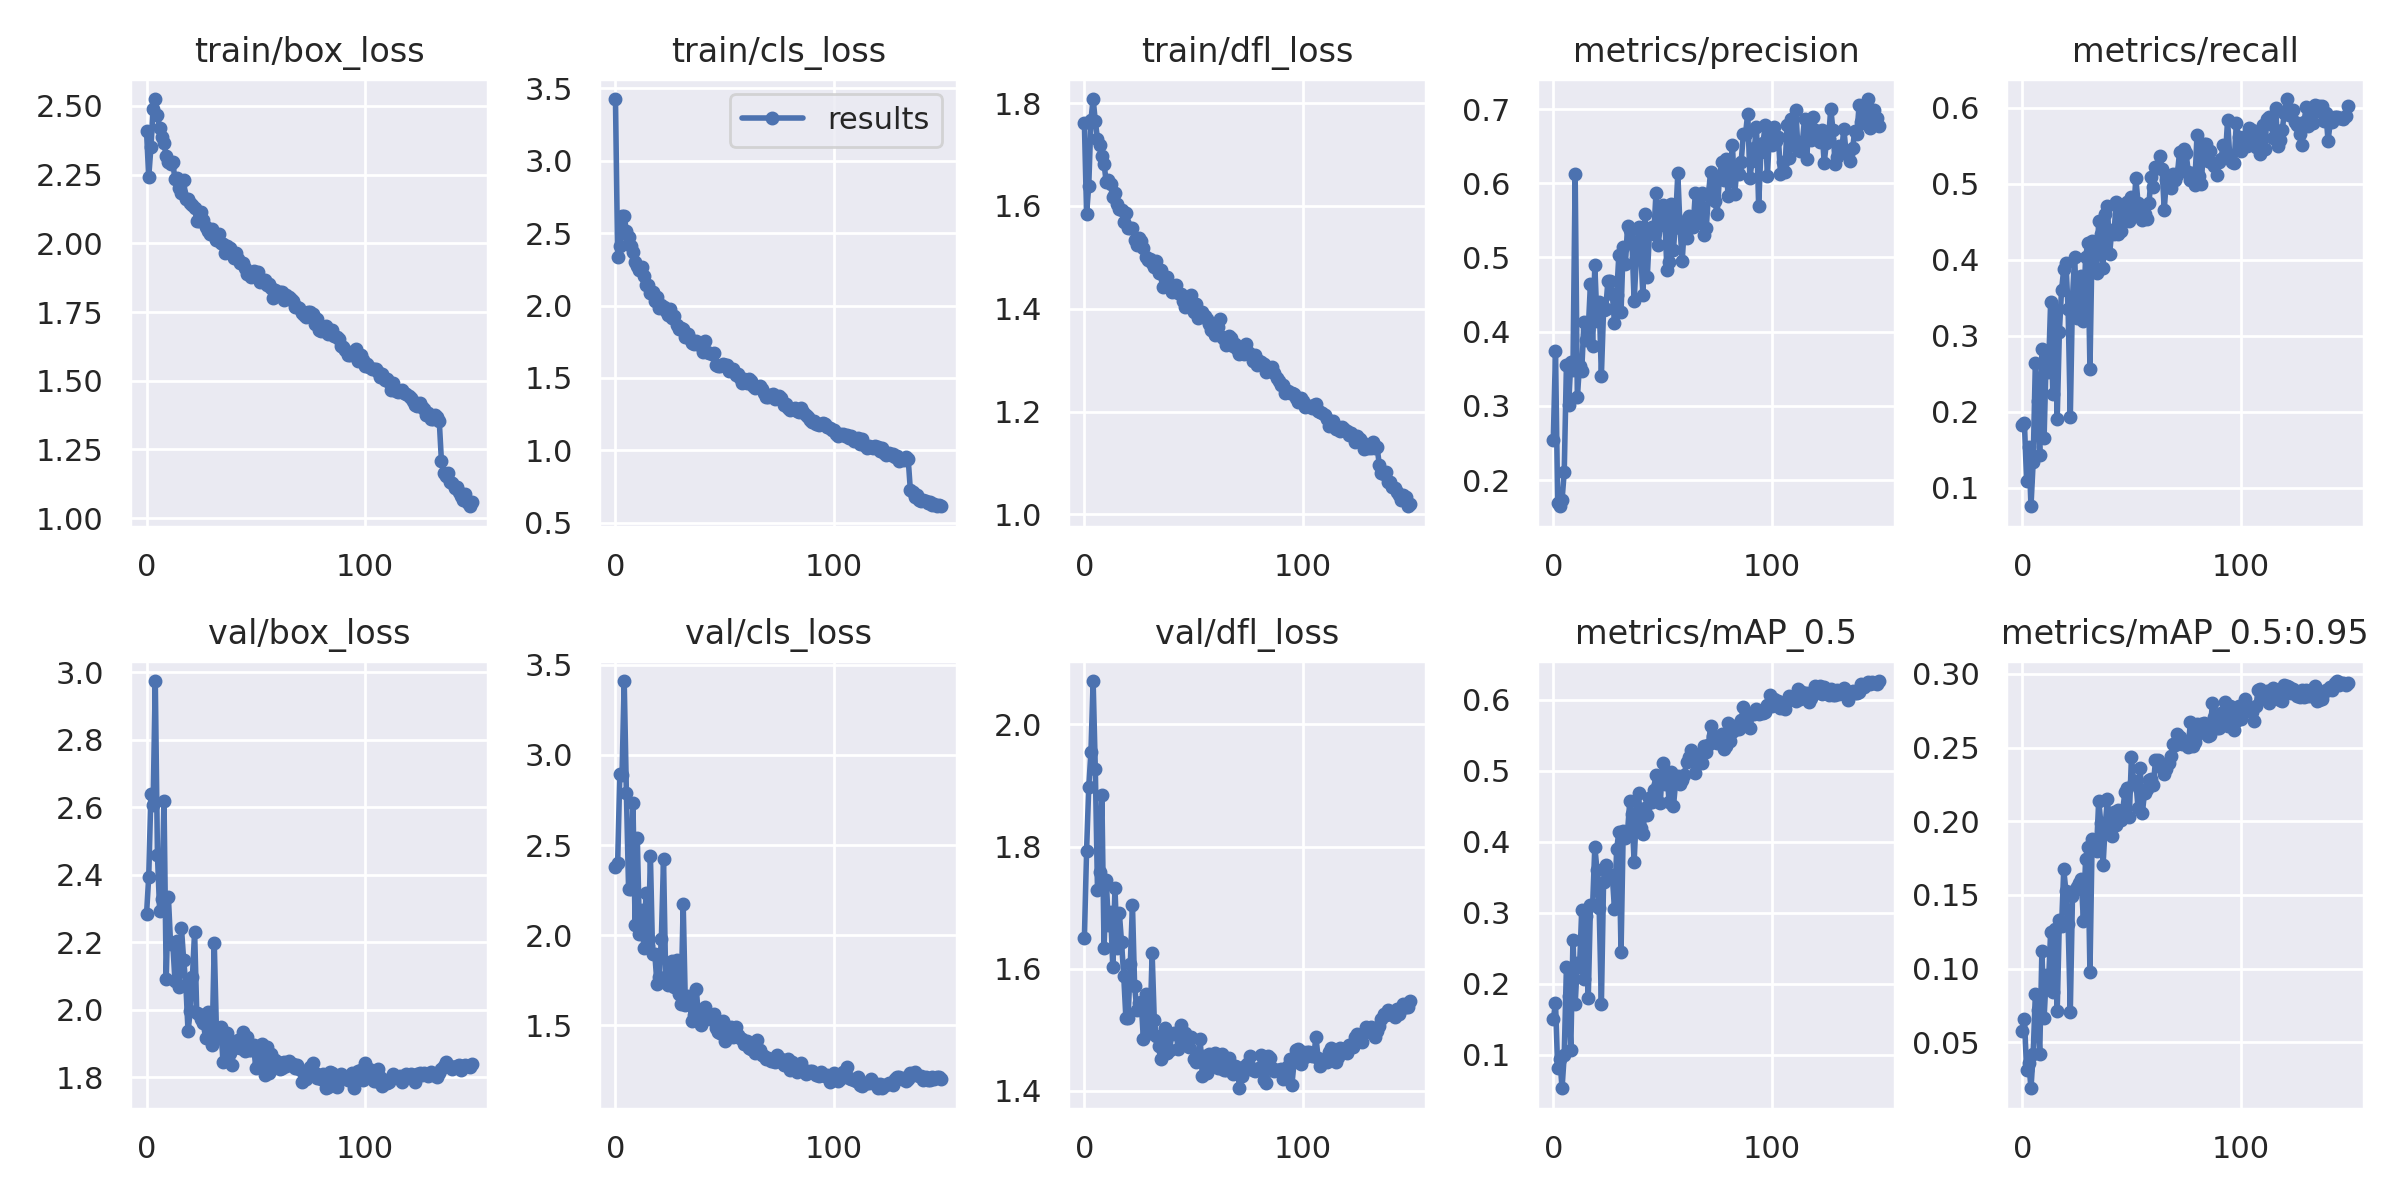

In [ ]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/results.png", width=1000)

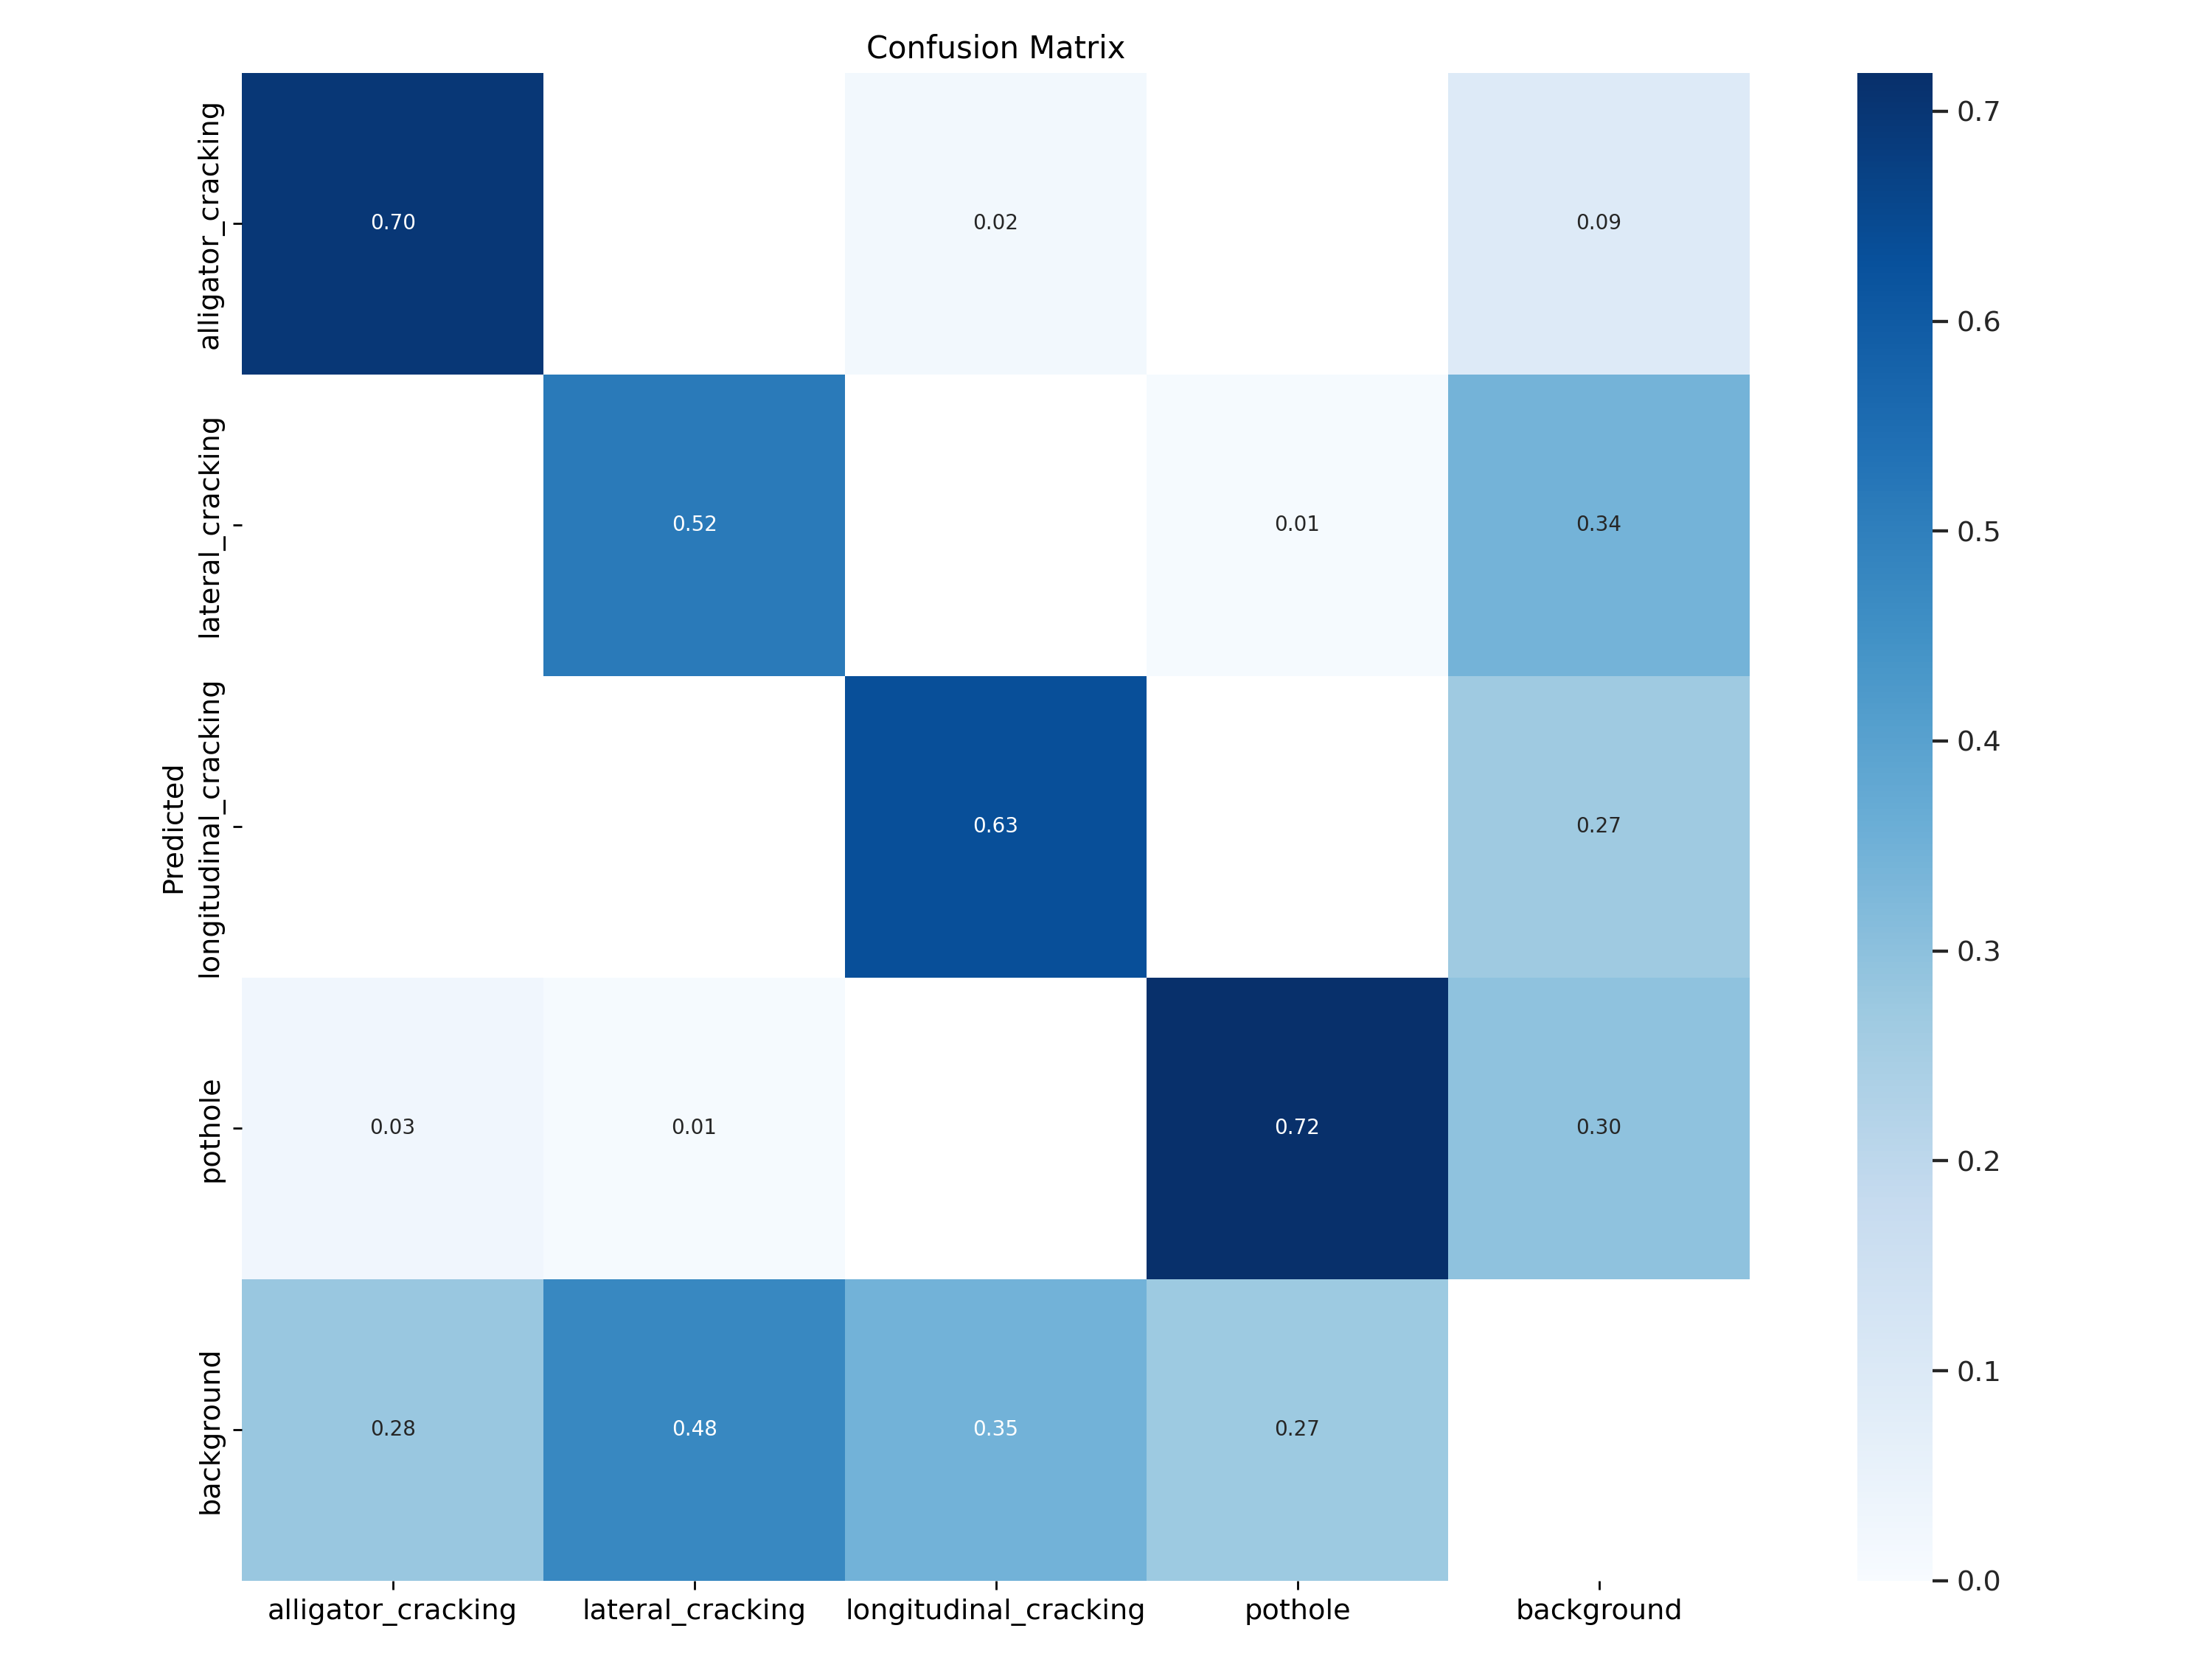

In [ ]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/confusion_matrix.png", width=1000)

## Precision

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

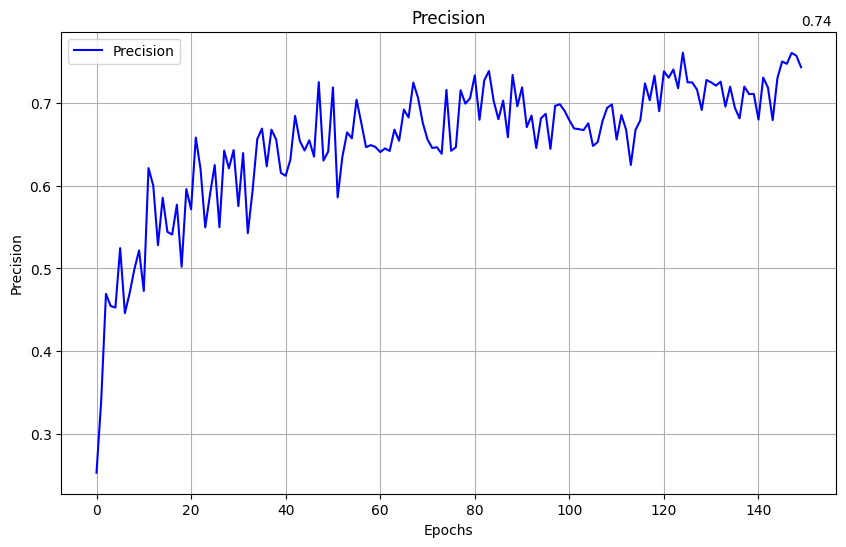

In [ ]:
# Baca data dari file CSV
csv_path = '/content/yolov9/runs/train/exp/results.csv'
data = pd.read_csv(csv_path)

# Ekstrak kolom precision
# Asumsikan bahwa kolom precision berada di indeks ke-4 (karena indeks mulai dari 0)
precision = data.iloc[:, 4]

# Buat grafik line chart
plt.figure(figsize=(10, 6))
plt.plot(precision, label='Precision', color='blue')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
last_value = precision.iloc[-1]
plt.annotate(f'{last_value:.2f}',
             xy=(len(precision)-1, last_value),
             xytext=(len(precision)-1, last_value + 0.05))
plt.show()

## Recall

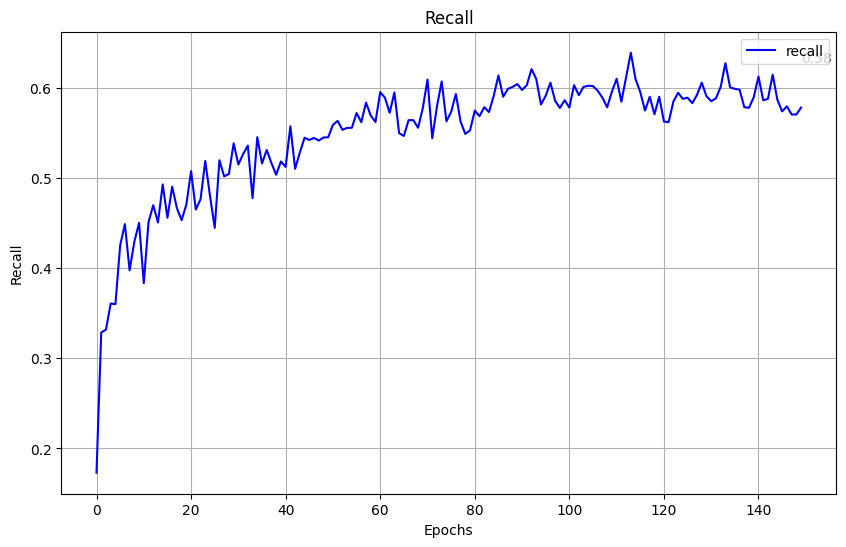

In [ ]:
recall = data.iloc[:, 5]

# Buat grafik line chart
plt.figure(figsize=(10, 6))
plt.plot(recall, label='recall', color='blue')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
last_value = recall.iloc[-1]
plt.annotate(f'{last_value:.2f}',
             xy=(len(recall)-1, last_value),
             xytext=(len(recall)-1, last_value + 0.05))
plt.show()

## mAP (mean Average Precision)

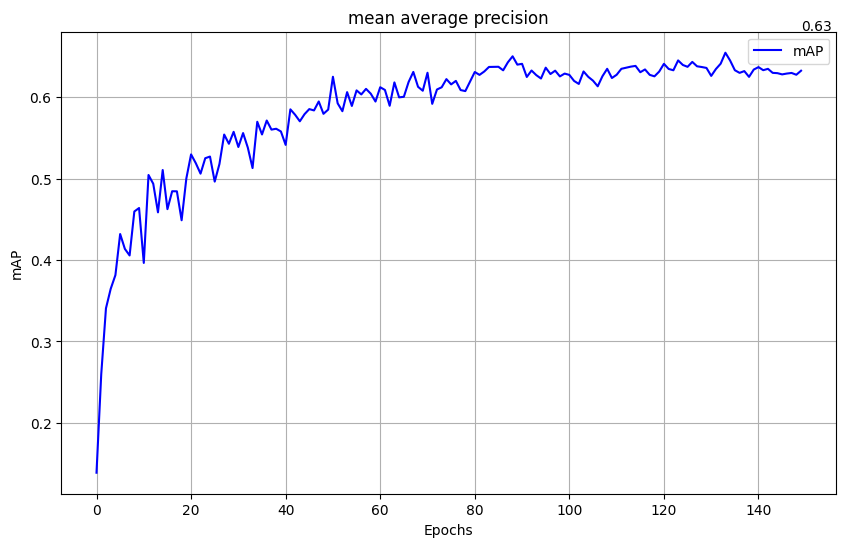

In [ ]:
mAP = data.iloc[:, 6]

# Buat grafik line chart
plt.figure(figsize=(10, 6))
plt.plot(mAP, label='mAP', color='blue')
plt.title('mean average precision')
plt.xlabel('Epochs')
plt.ylabel('mAP')
plt.legend()
plt.grid(True)
last_value = mAP.iloc[-1]
plt.annotate(f'{last_value:.2f}',
             xy=(len(mAP)-1, last_value),
             xytext=(len(mAP)-1, last_value + 0.05))

# Show the plot
plt.show()

# Testing

In [ ]:
%cd {HOME}/yolov9
# iou 0.6
!python val.py \
--img 640 --batch 16 --conf 0.5 --iou 0.6 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt

/content/yolov9
val: data=/content/yolov9/Deteksi-Kerusakan-Jalan-26/data.yaml, weights=['/content/yolov9/runs/train/exp/weights/best.pt'], batch_size=16, imgsz=640, conf_thres=0.5, iou_thres=0.6, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
WARNING ⚠️ confidence threshold 0.5 > 0.001 produces invalid results
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future relea

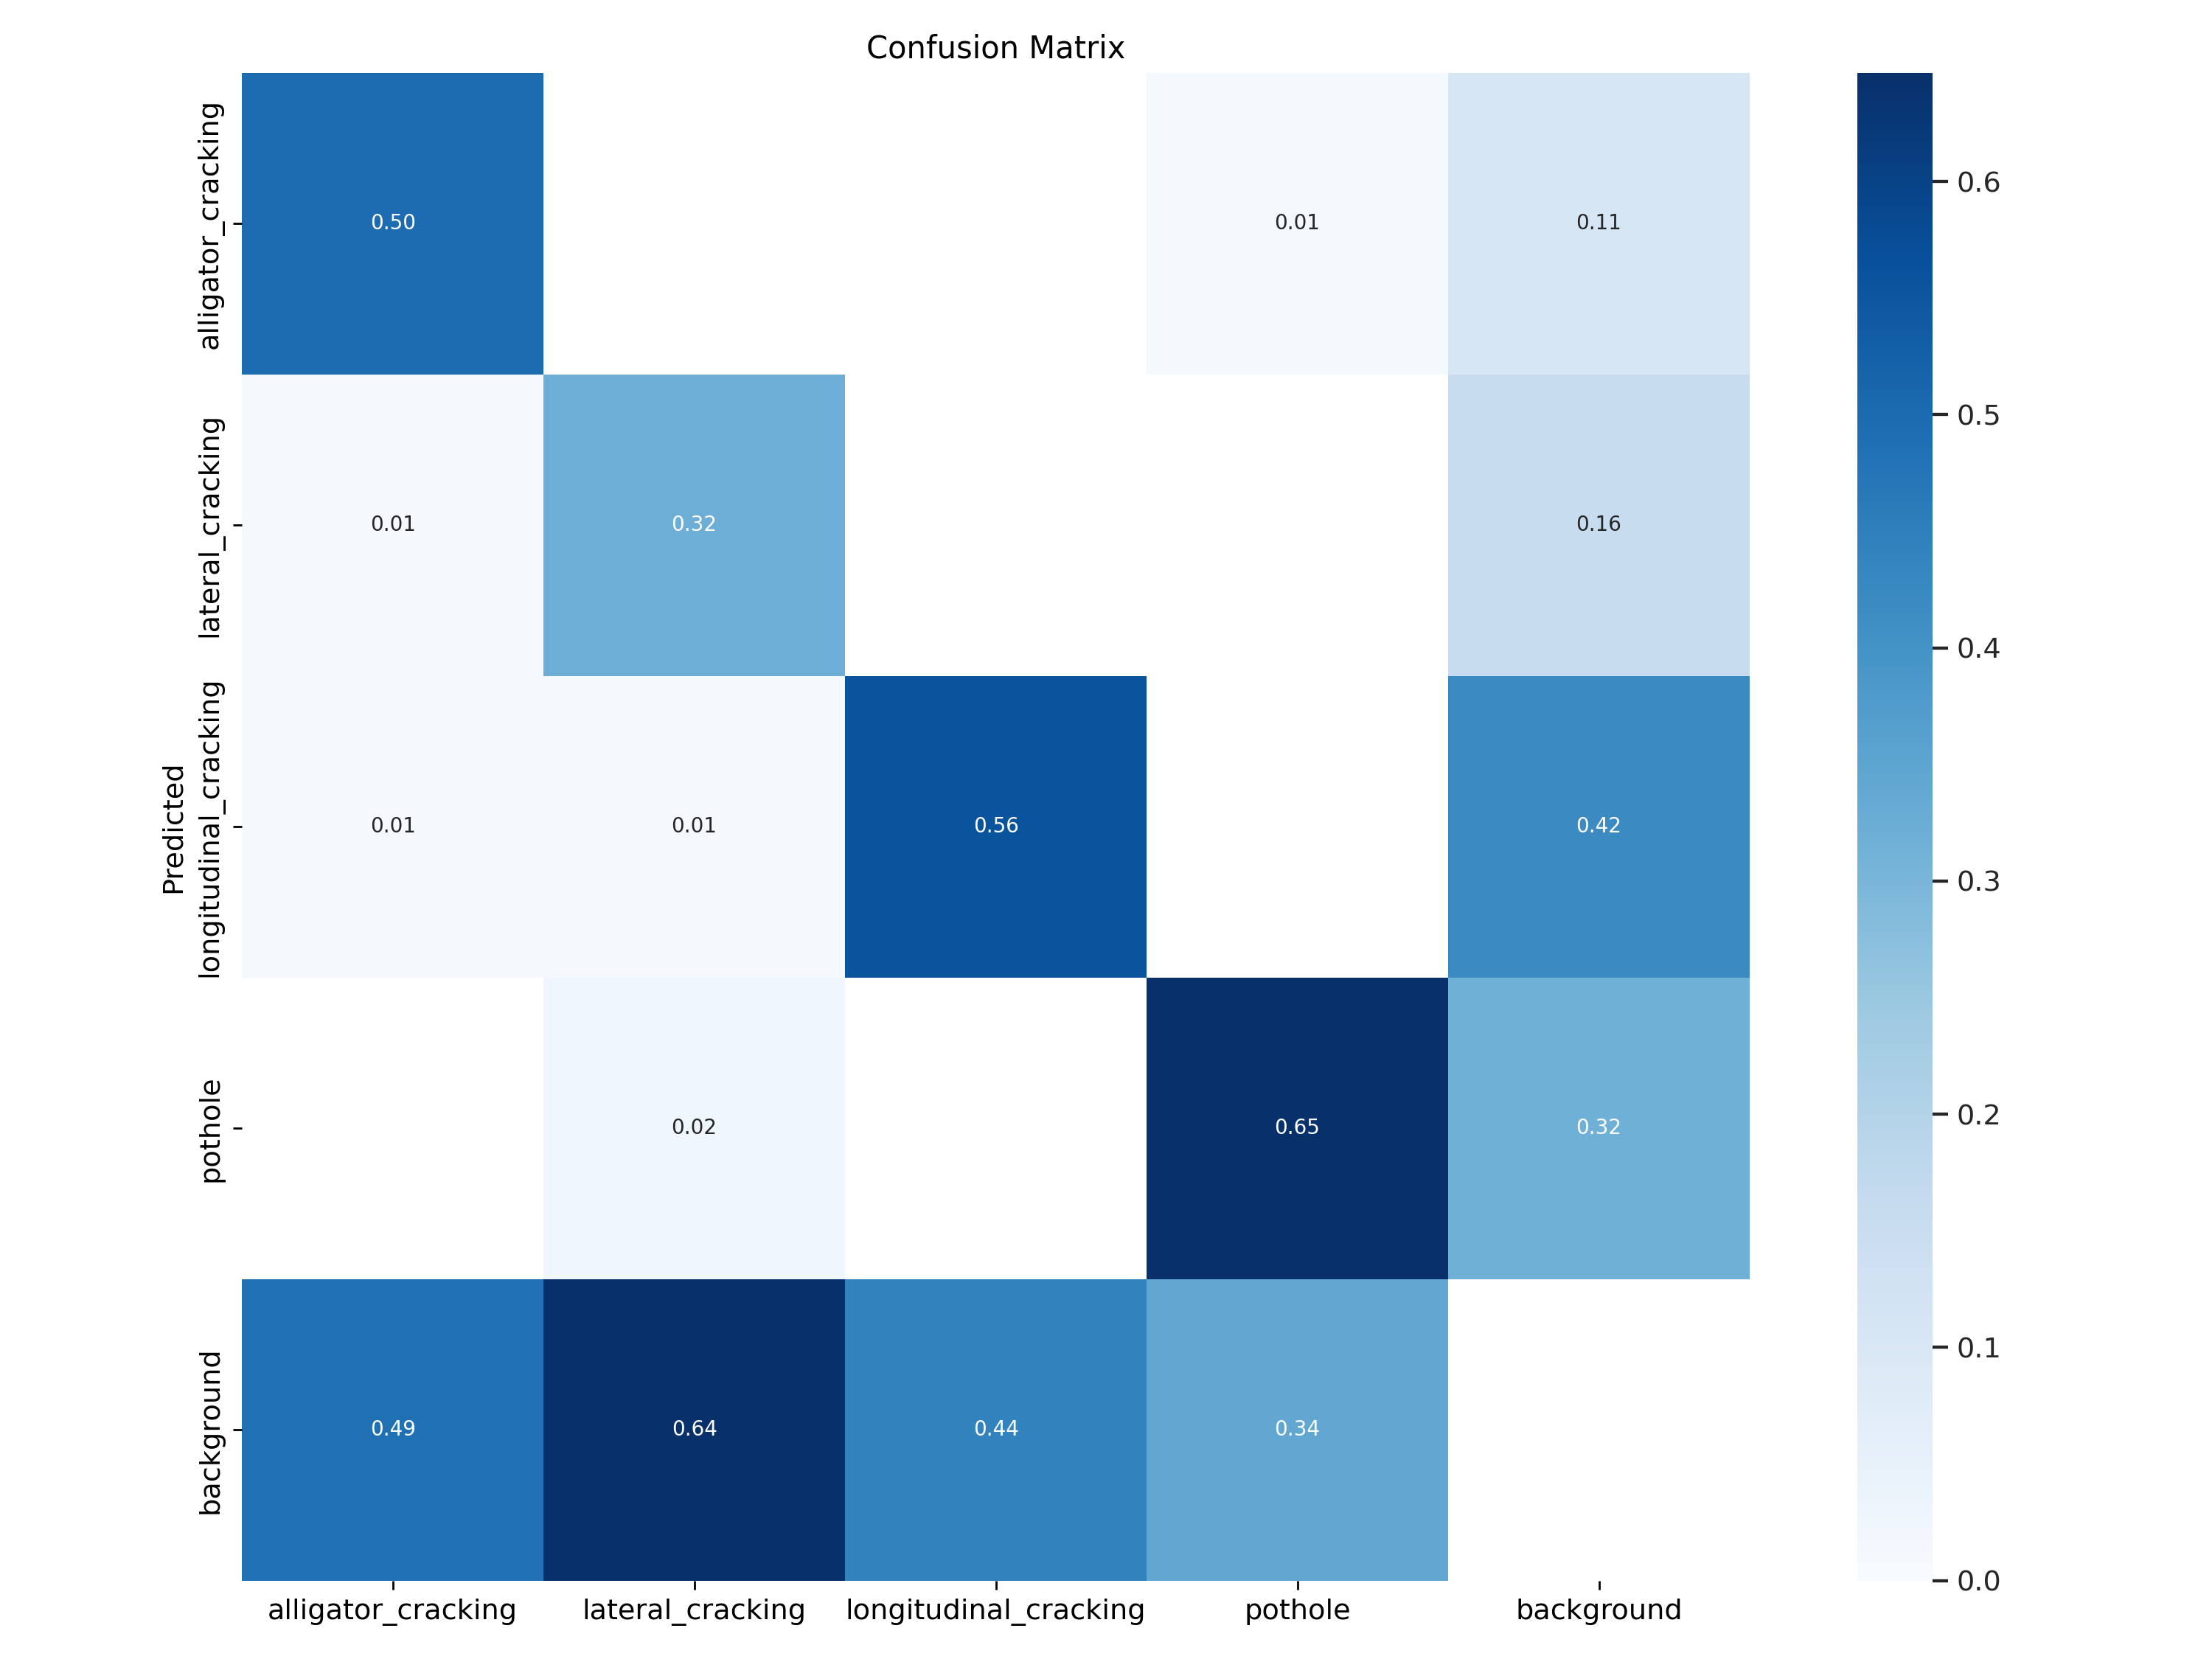

In [ ]:
from IPython.display import Image
Image(filename=f"{HOME}/yolov9/runs/val/exp4/confusion_matrix.png", width=1000)

# Inference

##Pictures

In [ ]:
%cd {HOME}/yolov9

!python detect.py \
--img 640 --conf 0.5 --device 0 \
--weights /content/yolov9/runs/train/exp/weights/best.pt \
--source /content/yolov9/Deteksi-Kerusakan-Jalan-26/test/images

/content/yolov9
detect: weights=['/content/yolov9/runs/train/exp/weights/best.pt'], source=/content/yolov9/Deteksi-Kerusakan-Jalan-26/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models 

In [ ]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'/yolov9/runs/detect/exp2/*.jpeg')[:2]:
      display(Image(filename=image_path, width=600))

##Videos

In [ ]:
!python detect.py \
--img 1920 --conf 0.5 --device 0 \
--weights /content/yolov9/train/exp/weights/best.pt \
--source /content/drive/MyDrive/video1/5_VID_20240418_102920.mp4

detect: weights=['/content/yolov9/train/exp/weights/best.pt'], source=/content/drive/MyDrive/video1/5_VID_20240418_102920.mp4, data=data/coco128.yaml, imgsz=[1920, 1920], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details).

In [ ]:
!python detect.py \
--img 1920 --conf 0.5 --device 0 \
--weights /content/yolov9/train/exp/weights/best.pt \
--source /content/drive/MyDrive/Video/6_VID_20240418_103317_1.mp4

Output streaming akan dipotong hingga 5000 baris terakhir.
video 1/1 (3515/8512) /content/drive/MyDrive/Video/6_VID_20240418_103317_1.mp4: 1088x1920 (no detections), 142.6ms
video 1/1 (3516/8512) /content/drive/MyDrive/Video/6_VID_20240418_103317_1.mp4: 1088x1920 1 lateral_cracking, 142.9ms
video 1/1 (3517/8512) /content/drive/MyDrive/Video/6_VID_20240418_103317_1.mp4: 1088x1920 (no detections), 144.0ms
video 1/1 (3518/8512) /content/drive/MyDrive/Video/6_VID_20240418_103317_1.mp4: 1088x1920 (no detections), 144.7ms
video 1/1 (3519/8512) /content/drive/MyDrive/Video/6_VID_20240418_103317_1.mp4: 1088x1920 (no detections), 143.8ms
video 1/1 (3520/8512) /content/drive/MyDrive/Video/6_VID_20240418_103317_1.mp4: 1088x1920 (no detections), 143.3ms
video 1/1 (3521/8512) /content/drive/MyDrive/Video/6_VID_20240418_103317_1.mp4: 1088x1920 (no detections), 142.9ms
video 1/1 (3522/8512) /content/drive/MyDrive/Video/6_VID_20240418_103317_1.mp4: 1088x1920 (no detections), 144.0ms
video 1/1 (3523/85

# Save to Drive

In [ ]:
from google.colab import drive
import os

In [ ]:
# Navigate to the folder
os.chdir('/content/yolov9/runs/detect')

# Zip the folder
!zip -r hasil_deteksi_citra.zip .

# Move the zip file to a different location in your Google Drive
!mv hasil_deteksi_citra.zip '/content/drive/MyDrive/results_yolov9'

# Optional: List files in the destination directory to confirm
!ls '/content/drive/MyDrive/results_yolov9'

  adding: exp/ (stored 0%)
  adding: exp/AD_15430_jpeg.rf.ffc7989795a3f0398828c97cee570842.jpg (deflated 6%)
  adding: exp/P_32250_jpeg.rf.ab6f085e157169935c21debd9cd5e43f.jpg (deflated 5%)
  adding: exp/T_5890_jpeg.rf.7e66dd0243d00f6bc1ee2772a56b85e2.jpg (deflated 5%)
  adding: exp/R_29610_jpeg.rf.af39a21875ac77834108d1f2486af59c.jpg (deflated 6%)
  adding: exp/AX_9070_jpeg.rf.94d4cf567b5d6474f6639b1a53482e80.jpg (deflated 6%)
  adding: exp/F_30070_jpeg.rf.66c2b13ffe192898e883692b6fa71d3f.jpg (deflated 5%)
  adding: exp/AF_14960_jpeg.rf.f57eb11cd1226202af1cb97e8eaf81c4.jpg (deflated 5%)
  adding: exp/O_5050_jpeg.rf.7a3be368173d0c06e5b1f3108a009073.jpg (deflated 6%)
  adding: exp/H_5290_jpeg.rf.028b10dfc838f784e54af7b5978556ec.jpg (deflated 6%)
  adding: exp/Y_33450_jpeg.rf.64a20fdf71fbc0c943b5524bd8a7bf5b.jpg (deflated 5%)
  adding: exp/R_7490_jpeg.rf.e158015eef277bd1d7af0ea69ec0e743.jpg (deflated 6%)
  adding: exp/Q_5320_jpeg.rf.47be4e9111d9ef7a52cbbc61c4c665b3.jpg (deflated 6%)
  ad